<a href="https://colab.research.google.com/github/irfanfarid02/irfan-resolusi/blob/main/revisi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import library yang diperlukan

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
!pip install -q pandas sastrawi scikit-learn
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from google.colab import files
import re
import nltk

# Download stopwords untuk Bahasa Indonesia
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('indonesian'))
from IPython.display import display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 1.8 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Load dataset dari file CSV
data = pd.read_csv('/content/23510reviewchatgpt.csv', encoding='latin1', delimiter=';')
data.head()

#data = pd.read_csv('/content/23510reviewchatgpt.csv', sep=';')
#data.head()


,Column1,content
0,12916,Untuk pencipta apk ini terimah kasih yah Sudah...
1,12364,bagus
2,12964,keren banget dah ?
3,12205,"Lumayan bagus sih, hanya saja mungkin untuk tu..."
4,12470,Sangat bagus


In [ ]:
data=data[['content']]
data.head()

,content
0,Untuk pencipta apk ini terimah kasih yah Sudah...
1,bagus
2,keren banget dah ?
3,"Lumayan bagus sih, hanya saja mungkin untuk tu..."
4,Sangat bagus


In [ ]:
# Hapus baris yang memiliki nilai NaN pada kolom 'content'
data.dropna(axis=0, subset=['content'], inplace=True)

In [ ]:
missing_info = pd.DataFrame({
    'missing_values': data.isnull().sum(),
    'percent_missing': data.isnull().mean() * 100
})
missing_info

,missing_values,percent_missing
content,0,0.0


In [ ]:
# Inisialisasi stemmer dari Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Upload file positive.tsv dan negative.tsv(lexicon sentimen indo)
uploaded = files.upload()

# Membaca positive dan negative lexicon dari file TSV
positive_lexicon = pd.read_csv('positive.tsv', sep='\t')
negative_lexicon = pd.read_csv('negative.tsv', sep='\t')

# Membuat kamus kata positif dan negatif untuk lookup
positive_dict = dict(zip(positive_lexicon['word'], positive_lexicon['weight']))
negative_dict = dict(zip(negative_lexicon['word'], negative_lexicon['weight']))

# Fungsi untuk menormalisasi kata-kata slang
def normalize_slang(content):
    slang_dict = {
        "gak": "tidak", "gbs": "tidak bisa", "ga": "tidak", "nggak": "tidak",
        "udah": "sudah", "aja": "saja", "mau": "ingin", "gue": "saya",
        "btw": "ngomong-ngomong", "tp": "tapi", "sy": "saya", "anjayyy ": "wah ",
        "ngulang": "mengulang", "yaa": "iya", "njay": " ", "mantaf": "mantap",
        "fokoknyah": "pokoknya", "gaada": "tidak ada, ", "gamau": "tidak mau",
        "pke": "pakai",
    }
    for slang, replacement in slang_dict.items():
        content = re.sub(r'\b' + slang + r'\b', replacement, content)
    return content


Saving negative.tsv to negative.tsv
Saving positive.tsv to positive.tsv


In [ ]:
# Cetak hasil teks sebelum normalisasi slang words
print("Sebelum Normalisasi Slang Words:")
df_content = pd.DataFrame(data['content'].head(10))  # Menampilkan 5 teks pertama sebelum normalisasi
styled_df = df_content.style.set_properties(**{'text-align': 'left'})
display(styled_df)

Sebelum Normalisasi Slang Words:


,content
0,Untuk pencipta apk ini terimah kasih yah Sudah membuat apk seperti ini Sukses selalu??????
1,bagus
2,keren banget dah ?
3,"Lumayan bagus sih, hanya saja mungkin untuk tutur bahasa Indonesia huruf ""R"" Sering dibaca tidak tepat, kesannya seperti bule ngomong indo."
4,Sangat bagus
5,sangat berguna
6,bagus
7,saya puas dengan apk ini!
8,ok
9,Sangat membantu saya ??


In [ ]:
# Fungsi untuk preprocessing teks (menghapus URL, non-alfabet, normalisasi slang)
def preprocess_content(content):
    content = re.sub(r'http\S+|www\S+|https\S+', '', content, flags=re.MULTILINE)  # Hapus URL
    content = re.sub('[^a-zA-Z0-9\s]', '', content)  # Hapus karakter non-alfabet
    content = content.lower() #Mengubah semua huruf pada content menjadi huruf kecil
    content = normalize_slang(content)  # Normalisasi slang
     # Hapus stopwords
    content = ' '.join([word for word in content.split() if word not in stop_words])
    return content


In [ ]:
# Terapkan normalisasi slang words
data['content'] = data['content'].apply(preprocess_content)

# Cetak hasil teks setelah normalisasi slang words
print("Setelah Normalisasi Slang Words:")
df_content = pd.DataFrame(data['content'].head(10))  # Menampilkan 5 teks pertama sebelum normalisasi
styled_df = df_content.style.set_properties(**{'text-align': 'left'})
display(styled_df)

Setelah Normalisasi Slang Words:


,content
0,pencipta apk terimah kasih yah apk sukses
1,bagus
2,keren banget dah
3,lumayan bagus sih bahasa indonesia huruf r dibaca kesannya bule ngomong indo
4,bagus
5,berguna
6,bagus
7,puas apk
8,ok
9,membantu


In [ ]:
# Cache untuk kata-kata yang sudah di-stem
stem_cache = {}
# Fungsi untuk preprocessing teks (stemming)
def stem_words(words):
    processed_words = []
    for word in words.split():  # 'words' berisi string dari kata-kata
        if word in stem_cache:
            processed_words.append(stem_cache[word])  # Ambil dari cache
        else:
            stemmed_word = stemmer.stem(word)  # Stem kata baru
            stem_cache[word] = stemmed_word  # Simpan di cache
            processed_words.append(stemmed_word)

    # Gabungkan kembali hasil preprocessing
    return ' '.join(processed_words)

In [ ]:
missing_info = pd.DataFrame({
    'missing_values': data.isnull().sum(),
    'percent_missing': data.isnull().mean() * 100
})
missing_info

,missing_values,percent_missing
content,0,0.0


In [ ]:
# Cek jumlah duplikat
duplicates = data.duplicated()
num_duplicates = duplicates.sum()

print(f"Jumlah duplikat dalam dataset: {num_duplicates}")


Jumlah duplikat dalam dataset: 12214


In [ ]:
# Contoh penggunaan
content = "menghilangkan."
preprocessed_content = preprocess_content(content)
stemmed_words = stem_words(preprocessed_content)
result = ' '.join(stemmed_words)

print(result)

h i l a n g


In [ ]:
# Cache untuk hasil pelabelan sentimen
sentiment_cache = {}

# Fungsi untuk mendapatkan label sentimen berdasarkan lexicon dengan caching
def get_sentiment(content):
    # Periksa apakah konten sudah ada dalam cache
    if content in sentiment_cache:
        return sentiment_cache[content]  # Ambil dari cache jika sudah ada

    # Melakukan stemming pada konten
    content_stemmed = stem_words(content)  # Stemming konten

    # Inisialisasi skor sentimen
    score = 0

    # Menghitung skor sentimen berdasarkan kata-kata di dalam konten
    for word in content_stemmed.split():
        if word in positive_dict:
            score += positive_dict[word]  # Tambahkan bobot dari kata positif
        elif word in negative_dict:
            score += negative_dict[word]  # Kurangkan bobot dari kata negatif

    # Tentukan label sentimen berdasarkan skor
    if score > 0:
        sentiment = 'Positive'
    elif score < 0:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'

    # Simpan hasil ke dalam cache
    sentiment_cache[content] = sentiment
    return sentiment

In [ ]:
duplicates = data[data['content'].duplicated()]
duplicates

,content
4,bagus
6,bagus
11,bagus
14,berguna
15,membantu
...,...
23504,login nya nomor telepon email maaf iya
23505,ngeleg
23506,update pengetahuan nya 2021 ketinggalan jaman
23507,


In [ ]:
data['content'][4]

'bagus'

In [ ]:
#data.drop_duplicates(subset='content', inplace=True)

In [ ]:
data['content'].duplicated().sum()

12214

In [ ]:
!pip install swifter
import swifter
import time

# Terapkan preprocessing pada kolom 'content' dengan swifter untuk pemrosesan cepat
start_time = time.time()
print("Memulai preprocessing...")
data['content'] = data['content'].swifter.apply(preprocess_content)
print(f"Preprocessing selesai dalam {time.time() - start_time:.2f} detik.")
# Terapkan pelabelan sentimen berdasarkan lexicon ke seluruh dataset
start_time = time.time()
print("Memulai pelabelan sentimen...")
data['sentiment'] = data['content'].swifter.apply(get_sentiment)
print(f"Pelabelan sentimen selesai dalam {time.time() - start_time:.2f} detik.")

# Tampilkan beberapa contoh hasil pelabelan sentimen
print("Contoh hasil pelabelan sentimen:")
display(data[['content', 'sentiment']].head(10))



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 12.7 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=d672062d524906876bd5d6a35c578baf02af3551d980234d1556f8409a5c1e4e
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter
Memulai preprocessing...


Pandas Apply:   0%|          | 0/23508 [00:00<?, ?it/s]

Preprocessing selesai dalam 1.21 detik.
Memulai pelabelan sentimen...


Pandas Apply:   0%|          | 0/23508 [00:00<?, ?it/s]

Pelabelan sentimen selesai dalam 1283.45 detik.
Contoh hasil pelabelan sentimen:


,content,sentiment
0,pencipta apk terimah kasih yah apk sukses,Positive
1,bagus,Positive
2,keren banget dah,Positive
3,lumayan bagus sih bahasa indonesia huruf r dib...,Positive
4,bagus,Positive
5,berguna,Positive
6,bagus,Positive
7,puas apk,Positive
8,ok,Positive
9,membantu,Positive


In [ ]:
# Simpan data ke dalam file CSV
#data.to_csv('data_sentiment.csv', index=False)

In [ ]:
# Memuat data dari file CSV
#data_loaded = pd.read_csv('data_sentiment12000.csv')
# Tampilkan data yang telah dimuat untuk memastikan
#display(data_loaded.head(10))

In [ ]:
# Tampilkan hasil pembagian data berdasarkan sentimen
print(f"Sentimen Positif: {len(data[data['sentiment'] == 'Positive'])}")
print(f"Sentimen Negatif: {len(data[data['sentiment'] == 'Negative'])}")
print(f"Sentimen Netral: {len(data[data['sentiment'] == 'Neutral'])}")

Sentimen Positif: 17380
Sentimen Negatif: 1546
Sentimen Netral: 4582


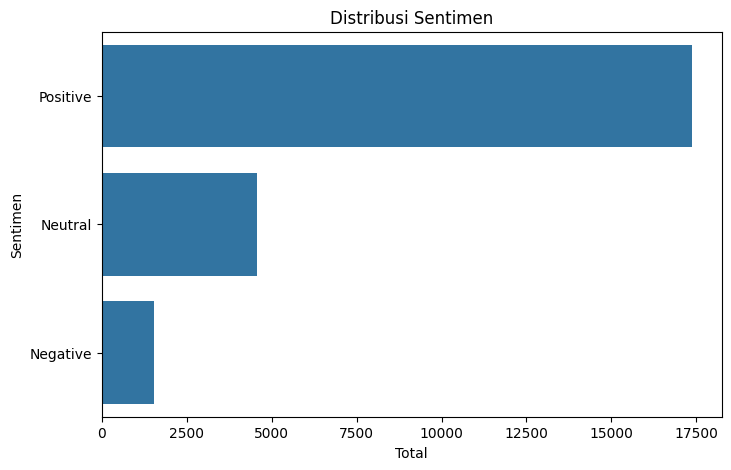

In [ ]:
# Visualisasi Sentimen
plt.figure(figsize=(8,5))
sns.countplot(data['sentiment'])
plt.title('Distribusi Sentimen')
plt.xlabel('Total')
plt.ylabel('Sentimen')
plt.show()

In [ ]:
# Tokenisasi dan padding untuk data
max_features = 5000  # Jumlah kata unik maksimum
MAX_SEQUENCE_LENGTH = 250  # Panjang maksimal sequence
EMBEDDING_DIM = 100  # Dimensi embedding

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(data['content'].values)
X = tokenizer.texts_to_sequences(data['content'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Encode 'sentiment' (label sentimen yang dihasilkan) sebagai one-hot encoding
y = pd.get_dummies(data['sentiment']).values  # One-hot encoding untuk 3 label sentimen

In [ ]:
# Bagi dataset menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(21157, 250) (21157, 3)
(2351, 250) (2351, 3)


In [ ]:
print(list(tokenizer.word_index.items())[:10])  # Menampilkan 10 kata pertama di word index


[('membantu', 1), ('bagus', 2), ('aplikasi', 3), ('mantap', 4), ('keren', 5), ('banget', 6), ('nya', 7), ('good', 8), ('chatgpt', 9), ('ai', 10)]


In [ ]:
#X = tokenizer.texts_to_sequences(data['content'].values)
print(X[:5])  # Menampilkan 5 urutan pertama


[[   0    0    0 ...  386   11  251]
 [   0    0    0 ...    0    0    2]
 [   0    0    0 ...    5    6  115]
 [   0    0    0 ... 4399  467  953]
 [   0    0    0 ...    0    0    2]]


In [ ]:
# Hasil Pembagian Dataset
print(f"Total data training: {len(X_train)}, Data testing: {len(X_test)}")
print(f"Total data: {len(data)}")


Total data training: 21157, Data testing: 2351
Total data: 23508


In [ ]:
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
model = Sequential()
model.add(Embedding(max_features, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.1))
model.add(LSTM(80, dropout=0.1, recurrent_dropout=0.1))#1
model.add(Dense(3, activation='softmax'))  # 3 kelas sentimen: Negatif, Netral, Positif

# Kompilasi model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping untuk menghindari overfitting
early_stop = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, min_delta=0.0001)]

# Train model
epochs = 15
batch_size =128
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stop])
print (model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
133/133 ━━━━━━━━━━━━━━━━━━━━ 94s 668ms/step - accuracy: 0.7696 - loss: 0.6411 - val_accuracy: 0.9109 - val_loss: 0.2635
Epoch 2/15
133/133 ━━━━━━━━━━━━━━━━━━━━ 86s 650ms/step - accuracy: 0.9234 - loss: 0.2231 - val_accuracy: 0.9405 - val_loss: 0.1747
Epoch 3/15
133/133 ━━━━━━━━━━━━━━━━━━━━ 88s 665ms/step - accuracy: 0.9667 - loss: 0.1150 - val_accuracy: 0.9518 - val_loss: 0.1630
Epoch 4/15
133/133 ━━━━━━━━━━━━━━━━━━━━ 143s 672ms/step - accuracy: 0.9785 - loss: 0.0815 - val_accuracy: 0.9584 - val_loss: 0.1394
Epoch 5/15
133/133 ━━━━━━━━━━━━━━━━━━━━ 140s 660ms/step - accuracy: 0.9877 - loss: 0.0566 - val_accuracy: 0.9582 - val_loss: 0.1442
Epoch 6/15
133/133 ━━━━━━━━━━━━━━━━━━━━ 146s 689ms/step - accuracy: 0.9893 - loss: 0.0460 - val_accuracy: 0.9608 - val_loss: 0.1445
Epoch 7/15
133/133 ━━━━━━━━━━━━━━━━━━━━ 140s 677ms/step - accuracy: 0.9902 - loss: 0.0403 - val_accuracy: 0.9608 - val_loss: 0.1508
Epoch 7: early stopping


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 250, 100)            │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 250, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 80)                  │          57,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             243 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,674,491 (6.39 MB)

 Trainable params: 558,163 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,116,328 (4.26 MB)

None


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
# Evaluasi model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step


In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Laporan klasifikasi
class_report = classification_report(y_test_classes, y_pred_classes, target_names=['Negative', 'Neutral', 'Positive'])
print("Classification Report:")
print(class_report)



Confusion Matrix:
[[ 142   17   26]
 [  10  405   33]
 [  11   23 1684]]
Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.77      0.82       185
     Neutral       0.91      0.90      0.91       448
    Positive       0.97      0.98      0.97      1718

    accuracy                           0.95      2351
   macro avg       0.92      0.88      0.90      2351
weighted avg       0.95      0.95      0.95      2351



In [ ]:
# Akurasi model LSTM
lstm_accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"LSTM Accuracy: {lstm_accuracy:.4f}")#91 0.5 9250 0,2 9200 0,1 9258 lstm64.0.1 (0,2 64)

LSTM Accuracy: 0.9490


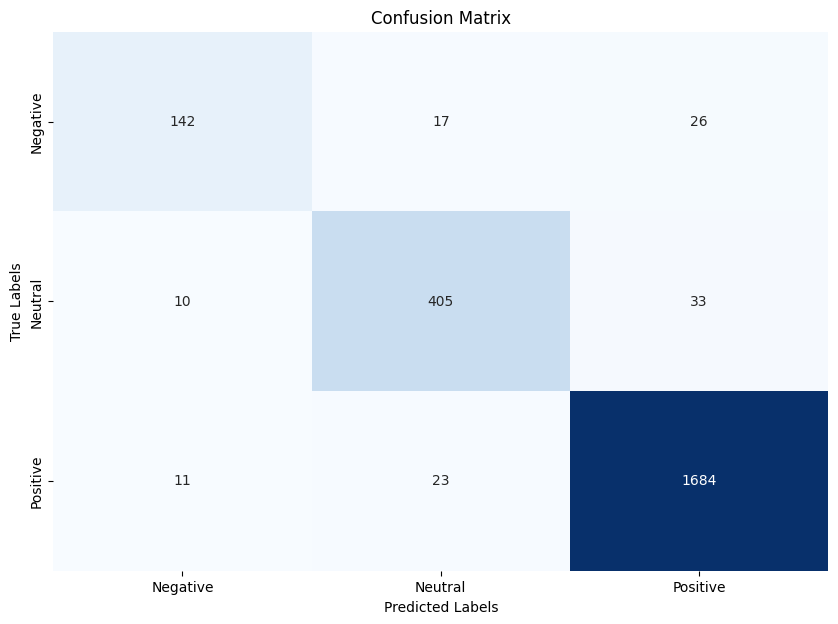

In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(conf_matrix, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(conf_matrix)

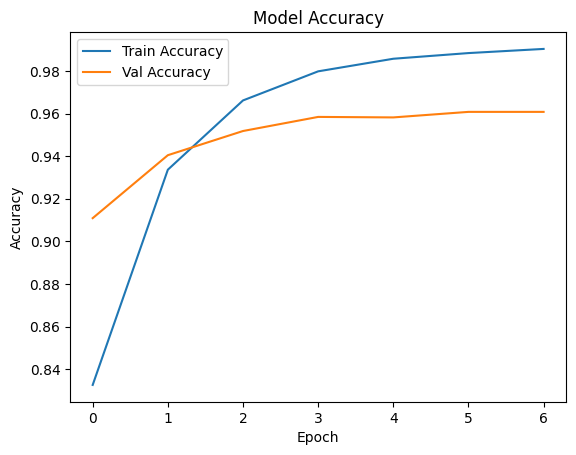

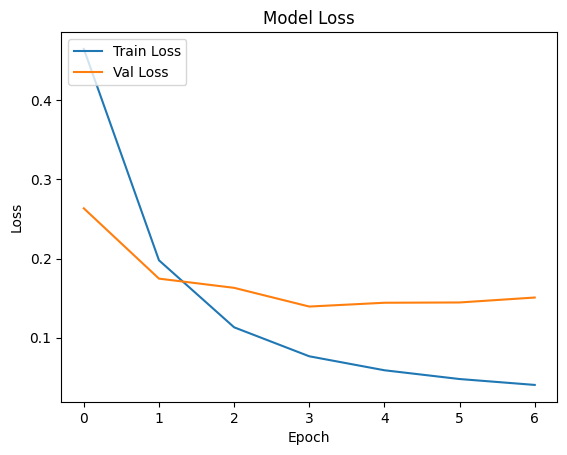

In [ ]:
# Plotting akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plotting loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

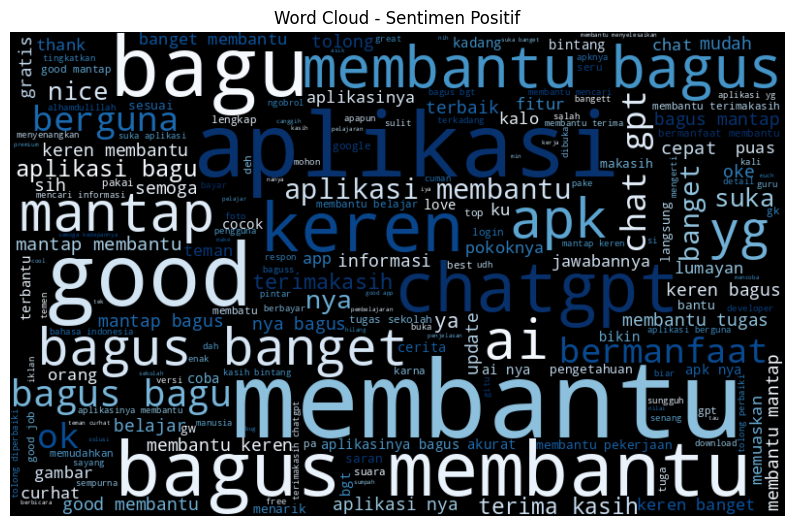

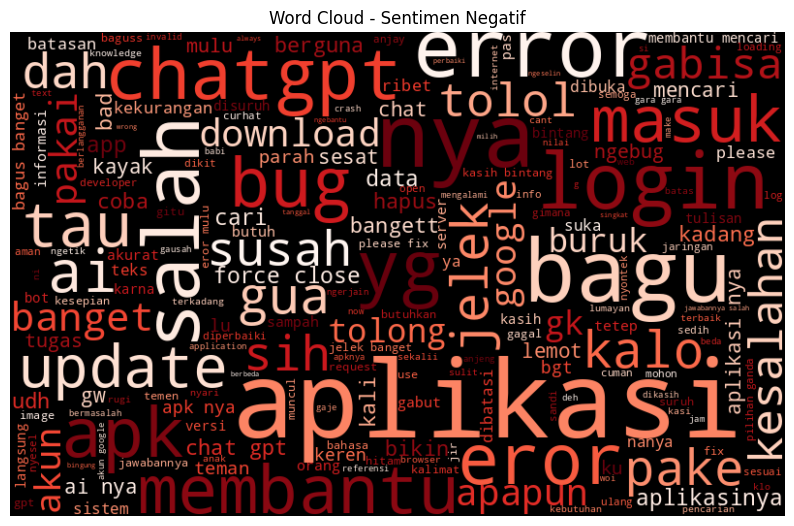

In [ ]:
from wordcloud import WordCloud
# Word Cloud untuk Sentimen Positif
positive_words = ' '.join([text for text in data[data['sentiment'] == 'Positive']['content']])
positive_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, colormap='Blues').generate(positive_words)

plt.figure(figsize=(10, 7))
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud - Sentimen Positif')
plt.show()

# Word Cloud untuk Sentimen Negatif
negative_words = ' '.join([text for text in data[data['sentiment'] == 'Negative']['content']])
negative_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, colormap='Reds').generate(negative_words)

plt.figure(figsize=(10, 7))
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud - Sentimen Negatif')
plt.show()

In [ ]:

# Tampilkan 3 contoh dari setiap kategori sentimen
def display_examples(sentiment_label):
    examples = data[data['sentiment'] == sentiment_label].head(5)
    print(f"\nContoh {sentiment_label} Sentiment:")
    for idx, row in examples.iterrows():
        print(f"{idx+1}. {row['content']}")

# Tampilkan contoh untuk sentimen negatif dan positif
display_examples('Negative')
display_examples('Positive')
display_examples('Neutral')


Contoh Negative Sentiment:
52. ai ngeselinnya ngeselin bener dah
75. teknologi berguna mencari
80. batasi gambar
143. it really helps me i always use it to be my daily chat friend this also makes a lot easier for me to find sources that are difficult to find on the internet
158. temen kesepian

Contoh Positive Sentiment:
1. pencipta apk terimah kasih yah apk sukses
2. bagus
3. keren banget dah
4. lumayan bagus sih bahasa indonesia huruf r dibaca kesannya bule ngomong indo
5. bagus

Contoh Neutral Sentiment:
19. manteb
22. ai lopyuuu pokoknyaa
43. anjaiiiiiiii
44. ship
47. kasih bintang 1


In [ ]:
# Fungsi untuk memproses kalimat input dan mengembalikan sentimen
def analyze_sentiment(input_text):
    # Preprocessing input text
    preprocessed_text = preprocess_content(input_text)

    # Mendapatkan sentimen dari teks yang sudah diproses
    sentiment = get_sentiment(preprocessed_text)

    return sentiment

# Fungsi untuk meminta input dari pengguna dan menganalisis sentimen
def main():
    print("silahkan mencoba analisis sentimen!")
    print("Masukkan kalimat untuk di analisis sentimen atau ketik '1' untuk selesai):")

    while True:
        user_input = input("\nMasukkan kalimat: ")

        # Memeriksa jika pengguna ingin keluar
        if user_input.lower() == '1':
            print("Terima kasih!")
            break

        # Menampilkan hasil sentimen
        try:
            sentiment_result = analyze_sentiment(user_input)
            print(f"Sentimen kalimat yang Anda masukkan adalah: {sentiment_result}")
        except Exception as e:
            print(f"Terjadi kesalahan: {e}. Mohon coba lagi.")

# Menjalankan fungsi utama
if __name__ == "__main__":
    main()


silahkan mencoba analisis sentimen!
Masukkan kalimat untuk di analisis sentimen atau ketik '1' untuk selesai):

Masukkan kalimat: 1
Terima kasih!
